In [2]:
!pip install d2l==0.16.1

In [3]:
from d2l import torch as d2l
import torch
from torch import nn

# Gated Recurrent Units (GRU)


In [ ]:


batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

### Initializing Model Parameters

The next step is to initialize the model parameters.
We draw the weights from a Gaussian distribution
with standard deviation to be 0.01 and set the bias to 0. The hyperparameter `num_hiddens` defines the number of hidden units.
We instantiate all weights and biases relating to the update gate, the reset gate, the candidate hidden state,
and the output layer.


In [ ]:
def get_params(vocab_size, num_hiddens, device):
    num_inputs = num_outputs = vocab_size

    def normal(shape):
        return torch.randn(size=shape, device=device)*0.01

    def three():
        return (normal((num_inputs, num_hiddens)),
                normal((num_hiddens, num_hiddens)),
                torch.zeros(num_hiddens, device=device))

    W_xz, W_hz, b_z = three()  # Update gate parameters
    W_xr, W_hr, b_r = three()  # Reset gate parameters
    W_xh, W_hh, b_h = three()  # Candidate hidden state parameters
    # Output layer parameters
    W_hq = normal((num_hiddens, num_outputs))
    b_q = torch.zeros(num_outputs, device=device)
    # Attach gradients
    params = [W_xz, W_hz, b_z, W_xr, W_hr, b_r, W_xh, W_hh, b_h, W_hq, b_q]
    for param in params:
        param.requires_grad_(True)
    return params

### Defining the Model




In [ ]:
def init_gru_state(batch_size, num_hiddens, device):
    return (torch.zeros((batch_size, num_hiddens), device=device), )

Now we are ready to define the GRU model.
Its structure is the same as that of the basic RNN cell, except that the update equations are more complex.


In [ ]:
def gru(inputs, state, params):
    W_xz, W_hz, b_z, W_xr, W_hr, b_r, W_xh, W_hh, b_h, W_hq, b_q = params
    H, = state
    outputs = []
    for X in inputs:
        Z = torch.sigmoid((X @ W_xz) + (H @ W_hz) + b_z)
        R = torch.sigmoid((X @ W_xr) + (H @ W_hr) + b_r)
        H_tilda = torch.tanh((X @ W_xh) + ((R * H) @ W_hh) + b_h)
        H = Z * H + (1 - Z) * H_tilda
        Y = H @ W_hq + b_q
        outputs.append(Y)
    return torch.cat(outputs, dim=0), (H,)

### Training and Prediction

Training and prediction work in exactly the same manner as in :numref:`sec_rnn_scratch`.
After training,
we print out the perplexity on the training set
and the predicted sequence following
the provided prefixes "time traveller" and "traveller", respectively.


perplexity 1.1, 24955.5 tokens/sec on cuda:0
time traveller for so it will be convenient to speak of himwas e


travelleris woubse travelleryou can show black is white by 


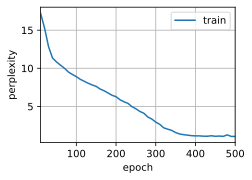

In [ ]:
vocab_size, num_hiddens, device = len(vocab), 256, d2l.try_gpu()
num_epochs, lr = 500, 1
model = d2l.RNNModelScratch(len(vocab), num_hiddens, device, get_params,
                            init_gru_state, gru)
d2l.train_ch8(model, train_iter, vocab, lr, num_epochs, device)

## Concise Implementation

In high-level APIs,
we can directly
instantiate a GPU model.
This encapsulates all the configuration detail that we made explicit above.
The code is significantly faster as it uses compiled operators rather than Python for many details that we spelled out before.


perplexity 1.0, 285515.4 tokens/sec on cuda:0
time travelleryou can show black is white by argument said filby


travelleryou can show black is white by argument said filby


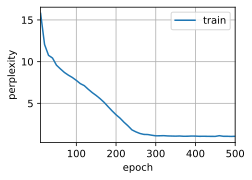

In [ ]:
num_inputs = vocab_size
gru_layer = nn.GRU(num_inputs, num_hiddens)
model = d2l.RNNModel(gru_layer, len(vocab))
model = model.to(device)
d2l.train_ch8(model, train_iter, vocab, lr, num_epochs, device)